In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"nadahamdi","key":"b72247aa1851f1d5f6367035f41b8432"}'}

In [ ]:

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d bittlingmayer/amazonreviews

Dataset URL: https://www.kaggle.com/datasets/bittlingmayer/amazonreviews
License(s): unknown
 98% 485M/493M [00:06<00:00, 104MB/s] 
100% 493M/493M [00:06<00:00, 81.4MB/s]


In [ ]:
!unzip amazonreviews.zip

Archive:  amazonreviews.zip
  inflating: test.ft.txt.bz2         
  inflating: train.ft.txt.bz2        


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')



> **Libraries**





In [ ]:
from tqdm import tqdm
from nltk.corpus import stopwords
from collections import Counter
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from wordcloud import WordCloud
#from spellchecker import SpellChecker
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import bz2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,SpatialDropout1D,Embedding
from keras.callbacks import ModelCheckpoint
import pickle

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import bz2
output_path='/train.ft.txt'
with bz2.open('/content/train.ft.txt.bz2','rt',encoding='utf-8') as compressed_file,open(output_path,'w',encoding='utf-8') as output_file:
    for line in compressed_file :
        output_file.write(line)
    print('Train Successful')

output_path='/test.ft.txt'
with bz2.open('/content/test.ft.txt.bz2','rt',encoding='utf-8') as compressed_file,open(output_path,'w',encoding='utf-8') as output_file:
    for line in compressed_file :
        output_file.write(line)
    print('Test Successful')

Train Successful
Test Successful


In [ ]:
train,test,train_labels,test_labels=[],[],[],[]
with open ('/train.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    train.append(line.split('__label__')[1][1:])
    train_labels.append(line.split('__label__')[1][0])
with open ('/test.ft.txt','r',encoding='utf-8') as file :
    lines=file.readlines()
for line in tqdm(lines):
    test.append(line.split('__label__')[1][1:])
    test_labels.append(line.split('__label__')[1][0])

100%|██████████| 400000/400000 [00:01<00:00, 364479.87it/s]


In [ ]:
train_data = {
  "review": train,
  "label": train_labels,
}
train_data = pd.DataFrame(train_data)
train_data=train_data.sample(n=500)
train_data.head()

,review,label
2208675,freaking fantastiic: i love this little heate...,2
3195595,Planet Earth - Blu-Ray - Stunning Picture Qua...,2
274452,Dont Go for it unless you fell for looks: I h...,1
949069,Martina McBandit strikes again!: This is the ...,1
2088168,This hub is not reliable: I bought this hub s...,1


In [ ]:
test_data = {
  "review": test,
  "label": test_labels,
}
test_data = pd.DataFrame(test_data)
test_data=test_data.sample(n=500)
test_data.head()

,review,label
256622,This game just plain ...: This is quite possi...,1
361094,Great Monitor: I have a dual display video ca...,2
174292,Too small: This blow dryer holder is too smal...,1
135694,George Brings Life to History: A wonderful ac...,2
261891,Was toast after 6 months!!! It is a joke of a...,1




#Data cleaning



 Convert to lower , remove special character and remove punctuation

In [ ]:
def clean_text(text):
    text=re.sub(r'[^a-zA-Z\s]','',text)
    text=re.sub(r'\s+',' ',text)
    text=text.lower()
    return text

In [ ]:
train_data["review"]=train_data["review"].apply(clean_text)


test_data["review"]=test_data["review"].apply(clean_text)

train_data['review'].head()

2208675     freaking fantastiic i love this little heater...
3195595     planet earth bluray stunning picture quality ...
274452      dont go for it unless you fell for looks i ha...
949069      martina mcbandit strikes again this is the se...
2088168     this hub is not reliable i bought this hub so...
Name: review, dtype: object

Remove stopwords

In [ ]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in STOPWORDS])

In [ ]:
train_data["review"] = train_data["review"].apply(remove_stopwords)

test_data["review"]= test_data["review"].apply( remove_stopwords)

train_data['review'].head()



2208675    freaking fantastiic love little heater monster...
3195595    planet earth bluray stunning picture quality h...
274452     dont go unless fell looks phone past months tm...
949069     martina mcbandit strikes second time cd rerele...
2088168    hub reliable bought hub could easily connect d...
Name: review, dtype: object

Remove frequent words

In [ ]:
word_count = Counter()
for text in train_data["review"]:
    for word in text.split():
        word_count[word] += 1


word_count.most_common(10)
FREQUENT_WORDS = set(word for (word, wc) in word_count.most_common(3))
def remove_freq_words(text):
    return " ".join([word for word in text.split() if word not in FREQUENT_WORDS])

In [ ]:
train_data["review"] = train_data["review"].apply( remove_freq_words)

test_data["review"]= test_data["review"].apply( remove_freq_words)
train_data['review'].head()



2518692    great bookterrible title third matrix destiny ...
3348314    item work box made cheaply dont know well item...
1896633    garmin rino purchased fist rino little less mo...
2379946    absolute tripe even real music nothing put bun...
1038151    hood horrors movie sucked big time brated acto...
Name: review, dtype: object

Remove rare words

In [ ]:
RARE_WORDS = set(word for (word, wc) in word_count.most_common()[:-10:-1])
def remove_rare_words(text):
    return " ".join([word for word in text.split() if word not in RARE_WORDS])

In [ ]:
train_data["review"] = train_data["review"].apply( remove_rare_words)

test_data["review"]= test_data["review"].apply( remove_rare_words)

train_data['review'].head()



2208675    freaking fantastiic love little heater monster...
3195595    planet earth bluray stunning picture quality h...
274452     dont go unless fell looks phone past months tm...
949069     martina mcbandit strikes second time cd rerele...
2088168    hub reliable bought hub could easily connect d...
Name: review, dtype: object

In [ ]:
# train_data["review_corrected"] = train_data["review"].apply(RARE_WORDS)
# test_data["review"] = test_data["review"].apply(RARE_WORDS)
# train_data.head()

 Spelling Correction

In [ ]:
!pip install pyspellchecker
from spellchecker import SpellChecker
spell = SpellChecker()

In [ ]:
from spellchecker import SpellChecker

def correct_spellings(text):
    # Create a SpellChecker object
    spell = SpellChecker()

    # Split the text into words
    words = text.split()

    # Initialize a list to store corrected words
    corrected_words = []

    # Iterate through each word in the text
    for word in words:
        # Check if the word is misspelled
        if spell.unknown([word]):
            # If misspelled, correct it
            corrected_word = spell.correction(word)
            if corrected_word is not None:
                corrected_words.append(corrected_word)
            else:
                # If the correction is None, keep the word unchanged
                corrected_words.append(word)
        else:
            # If correctly spelled, keep the word unchanged
            corrected_words.append(word)

    # Join the corrected words back into a single string
    corrected_text = ' '.join(corrected_words)

    return corrected_text



In [ ]:
train_data["review"] = train_data["review"].apply(correct_spellings)

test_data["review"] = test_data["review"].apply(correct_spellings)

### **Stemming & Lemmatization**


In [ ]:
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer

# Load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

# Initialize SnowballStemmer and WordNetLemmatizer
stemmer = SnowballStemmer(language='english')
lemmatizer = WordNetLemmatizer()

# Precompile regex patterns and load stopwords once
RE_HTML_TAG = re.compile(r'<.*?>')
RE_NON_ALPHA = re.compile(r'[^a-zA-Z\s]')
STOPWORDS = set(stopwords.words('english'))


def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove HTML tags
    text = RE_HTML_TAG.sub('', text)
    # ---------------------------------
    # removing short form:

    text=re.sub("isn't",'is not',text)
    text=re.sub("he's",'he is',text)
    text=re.sub("wasn't",'was not',text)
    text=re.sub("there's",'there is',text)
    text=re.sub("couldn't",'could not',text)
    text=re.sub("won't",'will not',text)
    text=re.sub("they're",'they are',text)
    text=re.sub("she's",'she is',text)
    text=re.sub("There's",'there is',text)
    text=re.sub("wouldn't",'would not',text)
    text=re.sub("haven't",'have not',text)
    text=re.sub("That's",'That is',text)
    text=re.sub("you've",'you have',text)
    text=re.sub("He's",'He is',text)
    text=re.sub("what's",'what is',text)
    text=re.sub("weren't",'were not',text)
    text=re.sub("we're",'we are',text)
    text=re.sub("hasn't",'has not',text)
    text=re.sub("you'd",'you would',text)
    text=re.sub("shouldn't",'should not',text)
    text=re.sub("let's",'let us',text)
    text=re.sub("they've",'they have',text)
    text=re.sub("You'll",'You will',text)
    text=re.sub("i'm",'i am',text)
    text=re.sub("we've",'we have',text)
    text=re.sub("it's",'it is',text)
    text=re.sub("don't",'do not',text)
    text=re.sub("that´s",'that is',text)
    text=re.sub("I´m",'I am',text)
    text=re.sub("it’s",'it is',text)
    text=re.sub("she´s",'she is',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('I’m','I am',text)
    text=re.sub('I’d','I did',text)
    text=re.sub("he’s'",'he is',text)
    text=re.sub('there’s','there is',text)
    # ---------------------------------

    # Remove special characters and numbers
    text = RE_NON_ALPHA.sub('', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stopwords
    tokens = [token for token in tokens if token not in STOPWORDS]

    # Apply stemming using SnowballStemmer
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    # Apply lemmatization using WordNetLemmatizer
    # lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Apply lemmatization using Spacy
    doc = nlp(" ".join(tokens))
    lemmatized_tokens = [token.lemma_ for token in doc]

    # Join back into a single string
    return ' '.join(lemmatized_tokens)

# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_data["review_corrected"] = train_data["review"].apply(preprocess_text)
test_data["review"] = test_data["review"].apply(preprocess_text)
train_data.head()

,review,label,review_corrected
2208675,freaking fantastiic love little heater monster...,2,freaking fantastiic love little heater monster...
3195595,planet earth bluray stunning picture quality h...,2,planet earth bluray stunning picture quality h...
274452,do not go unless fell look phone past month tm...,1,go unless fall look phone past month tmobile f...
949069,martina mcbandit strike second time cd rerelea...,1,martina mcbandit strike second time cd rerelea...
2088168,hub reliable buy hub could easily connect disc...,1,hub reliable buy hub could easily connect disc...


# Visualization

In [ ]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
vader = SentimentIntensityAnalyzer()
train_data["Score"] = train_data["review"].apply(
    lambda review: vader.polarity_scores(review)
)
train_data["Compound"] = train_data["Score"].apply(
    lambda score_dict: score_dict["compound"]
)
train_data["Sentiment"] = train_data["Compound"].apply(
    lambda sent: "positive" if sent > 0 else "negative"
)
train_data["Sentiment"].value_counts()

Sentiment
positive    354
negative    146
Name: count, dtype: int64

In [ ]:
train_data.head(10)

,review,label,Score,Compound,Sentiment
2518692,great bookterrible title third matrix destiny ...,2,"{'neg': 0.067, 'neu': 0.459, 'pos': 0.473, 'co...",0.9839,positive
3348314,item work box make cheaply know well item woul...,1,"{'neg': 0.049, 'neu': 0.578, 'pos': 0.373, 'co...",0.9856,positive
1896633,gamin ring purchase fist ring little less mont...,2,"{'neg': 0.0, 'neu': 0.868, 'pos': 0.132, 'comp...",0.4939,positive
2379946,absolute tripe even real music nothing put bun...,1,"{'neg': 0.032, 'neu': 0.846, 'pos': 0.123, 'co...",0.6705,positive
1038151,hood horror movie suck big time rate actor rat...,1,"{'neg': 0.44, 'neu': 0.483, 'pos': 0.077, 'com...",-0.9153,negative
1447254,live loan reread quote read aloud youth group ...,2,"{'neg': 0.077, 'neu': 0.758, 'pos': 0.165, 'co...",0.6124,positive
542123,duplicate effort little version big provide no...,1,"{'neg': 0.118, 'neu': 0.742, 'pos': 0.14, 'com...",-0.1280,negative
2203490,quirky character study twist fairly quiet leis...,2,"{'neg': 0.141, 'neu': 0.713, 'pos': 0.147, 'co...",0.0772,positive
3482372,every recipe winner purchase give gift dozen c...,2,"{'neg': 0.0, 'neu': 0.646, 'pos': 0.354, 'comp...",0.9552,positive
3401927,masterpiece box indeed glare omission entirely...,2,"{'neg': 0.0, 'neu': 0.45, 'pos': 0.55, 'compou...",0.9779,positive


In [ ]:
train_pos = train_data[train_data["Sentiment"] == "positive"]
train_neg = train_data[train_data["Sentiment"] == "negative"]


In [ ]:
class_data = train_data.groupby("Sentiment").count()["review"].reset_index().sort_values(by="review",ascending=False)
percent_class = class_data["review"]
labels = class_data["Sentiment"]

fig = px.pie(
    labels,
    values=percent_class,
    hole=0.4,
    names=labels, color=labels,
    title="Sentiment distribution",
    color_discrete_map={
        "positive": "#17C37B",
        "negative":"#F92969"
    }
)

fig.update_traces(
    title_font=dict(
        size=25,
        family="Verdana",
        color="darkred"
    ),
    hoverinfo="label+percent",
    textinfo="percent",
    textfont_size=20
)

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Positive", "Negative"))

review_pos = train_data[train_data["Sentiment"] == "positive"]["review"].str.len()
review_neg = train_data[train_data["Sentiment"] == "negative"]["review"].str.len()

fig.add_trace(
    go.Histogram(name="Positive", x=review_pos, marker=dict(color="#17C37B")), row=1, col=1
)
fig.add_trace(
    go.Histogram(name="Negative", x=review_neg, marker=dict(color="#F92969")), row=1, col=2
)



fig.update_layout(title="Number of characters in a review")

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Positive", "Negative"))

review_pos = train_data[train_data["Sentiment"] == "positive"]["review"].str.split().map(lambda x: len(x))
review_neg = train_data[train_data["Sentiment"] == "negative"]["review"].str.split().map(lambda x: len(x))


fig.add_trace(
    go.Histogram(name="Positive", x=review_pos, marker=dict(color="#17C37B")), row=1, col=1
)
fig.add_trace(
    go.Histogram(name="Negative", x=review_neg, marker=dict(color="#F92969")), row=1, col=2
)

fig.update_layout(title="Number of words in a review")

fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Positive", "Negative"))

word_pos = train_data[train_data["Sentiment"] == "positive"]["review"].str.split().apply(lambda x: [len(i) for i in x])
word_neg = train_data[train_data["Sentiment"] == "negative"]["review"].str.split().apply(lambda x: [len(i) for i in x])


fig.add_trace(
    go.Histogram(name="Positive", x=word_pos.map(lambda x: np.mean(x)), marker=dict(color="#17C37B")), row=1, col=1
)
fig.add_trace(
    go.Histogram(name="Negative", x=word_neg.map(lambda x: np.mean(x)), marker=dict(color="#F92969")), row=1, col=2
)


fig.update_layout(title="Average word length in each review")

fig.show()

In [ ]:
import pandas as pd
from collections import Counter
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = pd.DataFrame(columns=["Word", "Count"])

for train in [train_pos["review"], train_neg["review"]]:
    list_reviews = []
    for review in train:
        sentence = review.split(" ")
        for word in sentence:
            list_reviews.append(word)
    counter = Counter(list_reviews)
    word = [w[0] for w in counter.most_common(15)]
    count = [w[1] for w in counter.most_common(15)]
    df = pd.concat([df, pd.DataFrame({"Word": word, "Count": count})], ignore_index=True)

fig = make_subplots(rows=2, cols=1, subplot_titles=("Positive", "Negative"))

fig.add_trace(
    go.Bar(name="Positive", x=df["Word"][:15], y=df["Count"][:15], marker=dict(color="#17C37B")), row=1, col=1
)
fig.add_trace(
    go.Bar(name="Negative", x=df["Word"][15:], y=df["Count"][15:], marker=dict(color="#F92969")), row=2, col=1
)

fig.update_layout(title="Most common words by sentiment")
fig.show()


In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud



df = pd.DataFrame(columns=["Reviews"])

for train in [train_pos, train_neg]:
    tokenized_train = train["review"].apply(word_tokenize)

    comment_words = ""
    for review in tokenized_train:
        comment_words += " ".join(review) + " "

    df = pd.concat([df, pd.DataFrame({"Reviews": comment_words}, index=[0])], ignore_index=True)

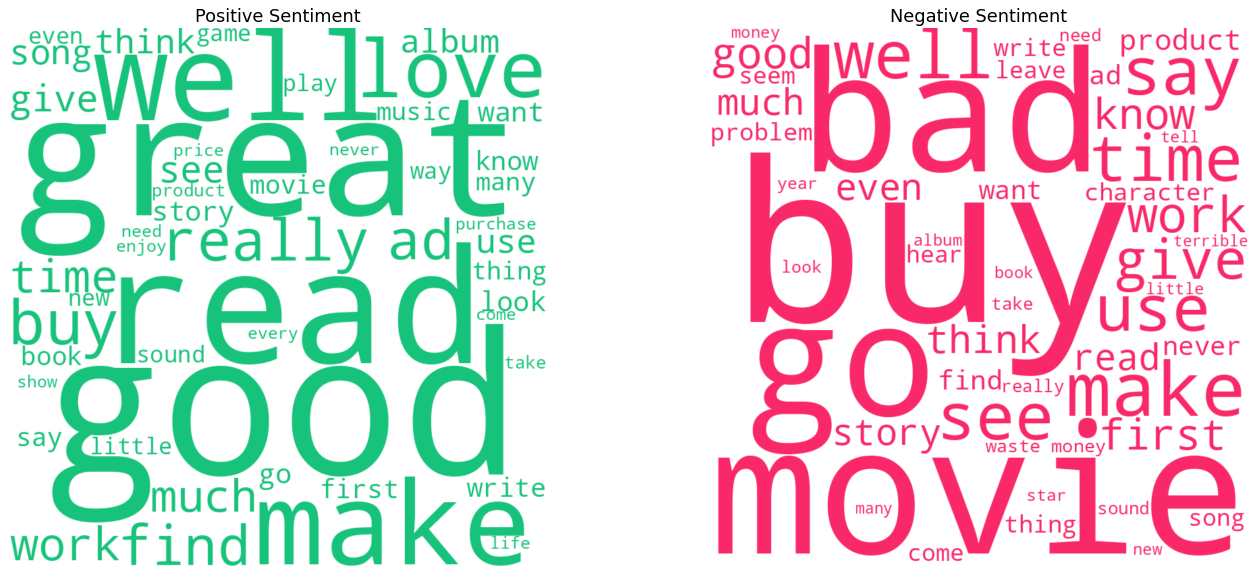

In [ ]:

list_colors = ["#17C37B", "#F92969"]
list_titles = ["Positive Sentiment", "Negative Sentiment"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True, dpi=80)

for i, ax in enumerate(axes):
    wc = WordCloud(
        width=800,
        height=800,
        max_words=50,
        min_font_size=10,
        background_color="white",
        colormap="tab10",
        color_func=lambda *args, **kwargs: list_colors[i],
        stopwords=None,
        prefer_horizontal=1.0
    )
    wc.generate(df["Reviews"][i])
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(list_titles[i], fontdict=dict(size=16))
    ax.axis("off")

plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()
